<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "ASC"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/ASC/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

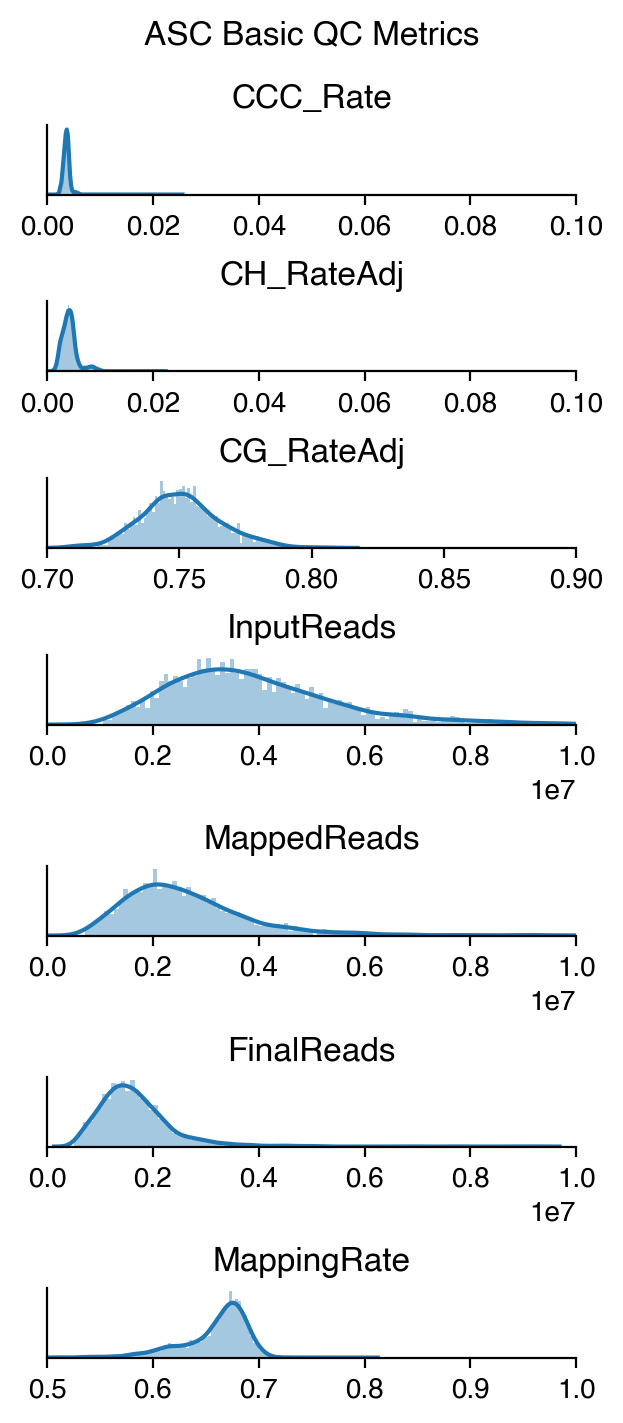

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

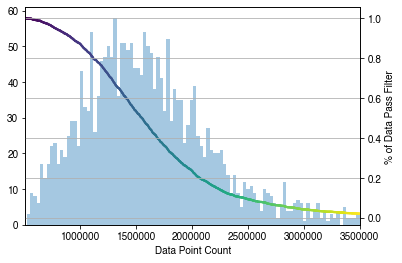

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2215/2215 (100.0%)
CG_RateAdj passed 2215/2215 (100.0%)
CH_RateAdj passed 2215/2215 (100.0%)
FinalReads passed 2215/2215 (100.0%)
MappingRate passed 2215/2215 (100.0%)
Overall passed 2215/2215 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 26
171207 21
171212 4
171213 11
171214 17
171219 27
180104 5
180109 28
180110 32
180111 17
180119 29
180122 13
180123 25
180129 9
180130 10
180205 8
180206 24
180208 36
180212 54
180213 23
180220 28
180222 25
180226 28
180227 18
180305 21
180306 18
180312 21
180313 7
180319 6
180320 24
180326 34
180329 23
180402 18
180403 31
180405 30
180409 26
180410 14
180412 32
180416 38
180417 28
180419 19
180423 32
180424 15
180426 26
180430 13
180501 28
180514 15
180529 12
180724 3
180806 20
180911 24
180917 25
180925 16
181002 15
181008 47
181009 40
181015 32
181016 43
181022 39
181023 31
181204 37
181206 69
181210 26
181218 13
181220 33
190108 28
190117 24
190122 32
190124 22
190131 32
190205 56
190207 59
190212 50
190214 79
190219 46
190305 68
190307 30
190625 10
190627 17
190711 57
190716 43


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 241 62.8%
ad002 283 73.7%
ad004 309 80.5%
ad006 281 73.2%
ad007 268 69.8%
ad008 275 71.6%
ad010 280 72.9%
ad012 278 72.4%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_1625,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003703,0.756083,0.755176,0.008400,0.004714,1964083.0,5215500,3322631.0,10E,...,-20.744740,1.028342,-29.545841,34.257260,ASC,-11.628026,7.796489,-24.453587,-22.410461,True
10E_M_1782,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003945,0.768285,0.767368,0.007797,0.003868,749582.0,2120744,1409712.0,10E,...,-22.012667,4.563080,-33.106262,24.003284,ASC,-1.318401,6.732799,19.894434,-30.896428,True
10E_M_1816,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.004101,0.749087,0.748054,0.008325,0.004241,1814332.0,5010328,3267790.0,10E,...,-21.320467,2.821705,-31.257153,28.733178,ASC,-6.845474,7.092499,-2.411730,-35.197254,True
10E_M_1996,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003842,0.756750,0.755812,0.009164,0.005342,1412966.0,4193404,2547449.0,10E,...,-21.114965,1.618457,-30.578571,31.129740,ASC,-8.680151,8.430105,-9.795020,-36.119598,True
10E_M_2000,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003920,0.756204,0.755245,0.006189,0.002278,1580249.0,4474590,2843479.0,10E,...,-21.758945,4.869758,-33.052742,23.596243,ASC,-1.770569,7.618982,17.947682,-33.161943,True
10E_M_2001,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003984,0.750463,0.749465,0.008023,0.004056,1964204.0,5487090,3554094.0,10E,...,-21.802662,1.971022,-32.066325,31.811767,ASC,-6.646505,7.082937,-0.008859,-35.606921,True
10E_M_2084,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003286,0.735205,0.734332,0.006453,0.003178,1166566.0,2948512,1863922.0,10E,...,-21.408707,3.483145,-32.302629,26.851491,ASC,-4.528514,6.645206,7.179373,-35.508200,True
10E_M_2087,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003604,0.749387,0.748481,0.006855,0.003263,1418259.0,3660338,2294299.0,10E,...,-21.523727,3.135921,-32.052760,27.447396,ASC,-4.970586,6.610440,5.064385,-38.444747,True
10E_M_2176,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003618,0.743064,0.742131,0.007608,0.004005,2135314.0,6045774,3981447.0,10E,...,-20.906292,2.563780,-30.460987,29.396537,ASC,-7.715209,6.274463,-5.639795,-38.592142,True
